In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import timm
import torch.nn as nn
from torch.utils.data import DataLoader  # DataLoaderのインポート
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# データのパス
data_dir = './images2'

# データ前処理
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# データセットを読み込む
image_datasets = {x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


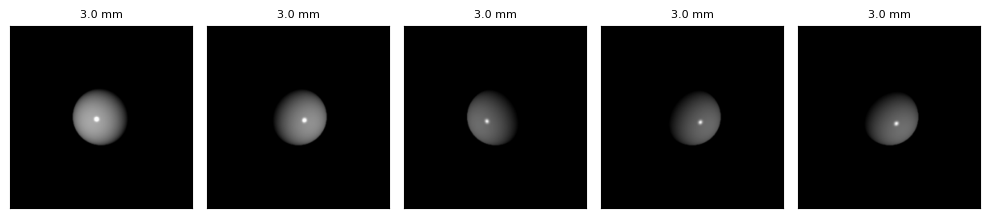

In [3]:
# すべての画像を表示（大量の場合は一部だけ表示するのがおすすめ）
train_dataset = image_datasets['train']
fig = plt.figure(figsize=(10, 10))

# クラス名を数値にマッピングする辞書を作成
label_map = {'3mm': 3.0, '5mm': 5.0}

# データセット内の画像を表示
for i in range(5):  # 5枚のみ表示
    img, label = train_dataset[i]  # 画像とラベルを取得

    # データを取得してラベルを数値に変換
    class_name = train_dataset.classes[label]  # クラス名を取得（例: '3mm'）
    label = label_map[class_name]  # クラス名から数値に変換

    # チャンネルの順番を変更して画像の形式を(高さ, 幅, チャンネル)に
    img = img.numpy().transpose((1, 2, 0))

    # 正規化を戻す
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # 正規化を元に戻す
    img = np.clip(img, 0, 1)  # 値を[0,1]範囲にクリップ

    # 画像をプロット
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"{label} mm", fontsize=8)  # 数値ラベルをタイトルに表示

plt.tight_layout()
plt.show()

In [4]:
model = models.densenet121(pretrained=True)

# 最後の全結合層を自分のクラス数に変更
num_ftrs = model.classifier.in_features  #classifier
model.classifier = nn.Linear(num_ftrs, 1)  # 回帰問題

# モデルをデバイスに転送（GPUがある場合）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 畳み込み層の重みを固定（勾配計算を行わないようにする）
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層だけ勾配計算を有効にする
for param in model.classifier.parameters():
    param.requires_grad = True

# 損失関数をMSELossに変更
criterion = nn.MSELoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=1e-3)  # 最後の層だけ最適化

num_epochs = 100

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # 各エポックでトレーニングとバリデーションを行う
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # トレーニングモード
        else:
            model.eval()  # 評価モード

        running_loss = 0.0
        running_mae = 0.0  # MAE用の変数

        # データローダーからバッチを取り出して学習
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = torch.tensor([label_map[class_names[label]] for label in labels], dtype=torch.float32).to(device)

            # 勾配を初期化
            optimizer.zero_grad()

            # 順伝播と逆伝播（トレーニング時のみ）
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                outputs = outputs.view(-1)  # 出力を1次元に変換
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # ロスとMAEを更新
            running_loss += loss.item() * inputs.size(0)
            running_mae += torch.sum(torch.abs(outputs - labels)).item()  # MAEの計算

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_mae = running_mae / dataset_sizes[phase]  # MAEをエポックごとに平均

        print(f'{phase} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

print("----------Finish----------")


Epoch [1/100]
train Loss: 14.8066 MAE: 3.7263
val Loss: 15.3155 MAE: 3.7883
Epoch [2/100]
train Loss: 6.6443 MAE: 2.4088
val Loss: 9.0406 MAE: 2.8400
Epoch [3/100]
train Loss: 2.1899 MAE: 1.2257
val Loss: 4.8852 MAE: 1.9541
Epoch [4/100]
train Loss: 0.7773 MAE: 0.7579
val Loss: 2.0495 MAE: 1.0886
Epoch [5/100]
train Loss: 1.2256 MAE: 0.9044
val Loss: 1.2877 MAE: 1.1029
Epoch [6/100]
train Loss: 1.8676 MAE: 1.1528
val Loss: 1.8439 MAE: 1.0552
Epoch [7/100]
train Loss: 1.9991 MAE: 1.1956
val Loss: 2.5243 MAE: 1.2085
Epoch [8/100]
train Loss: 1.5813 MAE: 1.0376
val Loss: 2.5445 MAE: 1.2378
Epoch [9/100]
train Loss: 0.9250 MAE: 0.7803
val Loss: 1.6953 MAE: 0.9430
Epoch [10/100]
train Loss: 0.5065 MAE: 0.6154
val Loss: 0.9494 MAE: 0.9086
Epoch [11/100]
train Loss: 0.5144 MAE: 0.6244
val Loss: 0.8835 MAE: 0.9174
Epoch [12/100]
train Loss: 0.6005 MAE: 0.6326
val Loss: 0.9271 MAE: 0.9342
Epoch [13/100]
train Loss: 0.6308 MAE: 0.6368
val Loss: 0.8675 MAE: 0.8861
Epoch [14/100]
train Loss: 0.528

In [6]:
# テストデータの前処理
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# テストデータセットを読み込む
test_dataset = datasets.ImageFolder(root='./images_test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# テストデータセットのサイズを取得
test_dataset_size = len(test_dataset)

# クラス名から数値にマッピング
label_map = {'3mm': 3.0, '5mm': 5.0}
class_names = test_dataset.classes

# モデルを評価モードに設定
model.eval()

# 評価用の変数を初期化
running_mae = 0.0
running_mse = 0.0  # MSE用の変数
all_preds = []
all_labels = []
all_images = []  # 画像を保存するリストを初期化

# テストデータを使って評価
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = torch.tensor([label_map[class_names[label]] for label in labels], dtype=torch.float32).to(device)

    # 順伝播のみ（勾配計算は不要）
    with torch.no_grad():
        outputs = model(inputs).view(-1)  # 出力を1次元に変換

    # MAEとMSEを計算
    running_mae += torch.sum(torch.abs(outputs - labels)).item()
    running_mse += torch.sum((outputs - labels) ** 2).item()  # MSEの計算

    # 予測結果とラベルをリストに保存
    all_preds.extend(outputs.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    
    # 入力画像もリストに保存（CPUに移動してnumpy配列に変換）
    all_images.extend(inputs.cpu().numpy())

# MAE, MSE, RMSEを計算
mae = running_mae / test_dataset_size
mse = running_mse / test_dataset_size
rmse = mse ** 0.5  # RMSEはMSEの平方根

# R^2スコアを計算
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
ss_total = np.sum((all_labels - np.mean(all_labels)) ** 2)
ss_residual = np.sum((all_labels - all_preds) ** 2)
r2_score = 1 - (ss_residual / ss_total)

# 結果を表示
print(f'Test MAE: {mae:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test R^2: {r2_score:.4f}')


Test MAE: 0.2852
Test MSE: 0.1452
Test RMSE: 0.3811
Test R^2: 0.8548


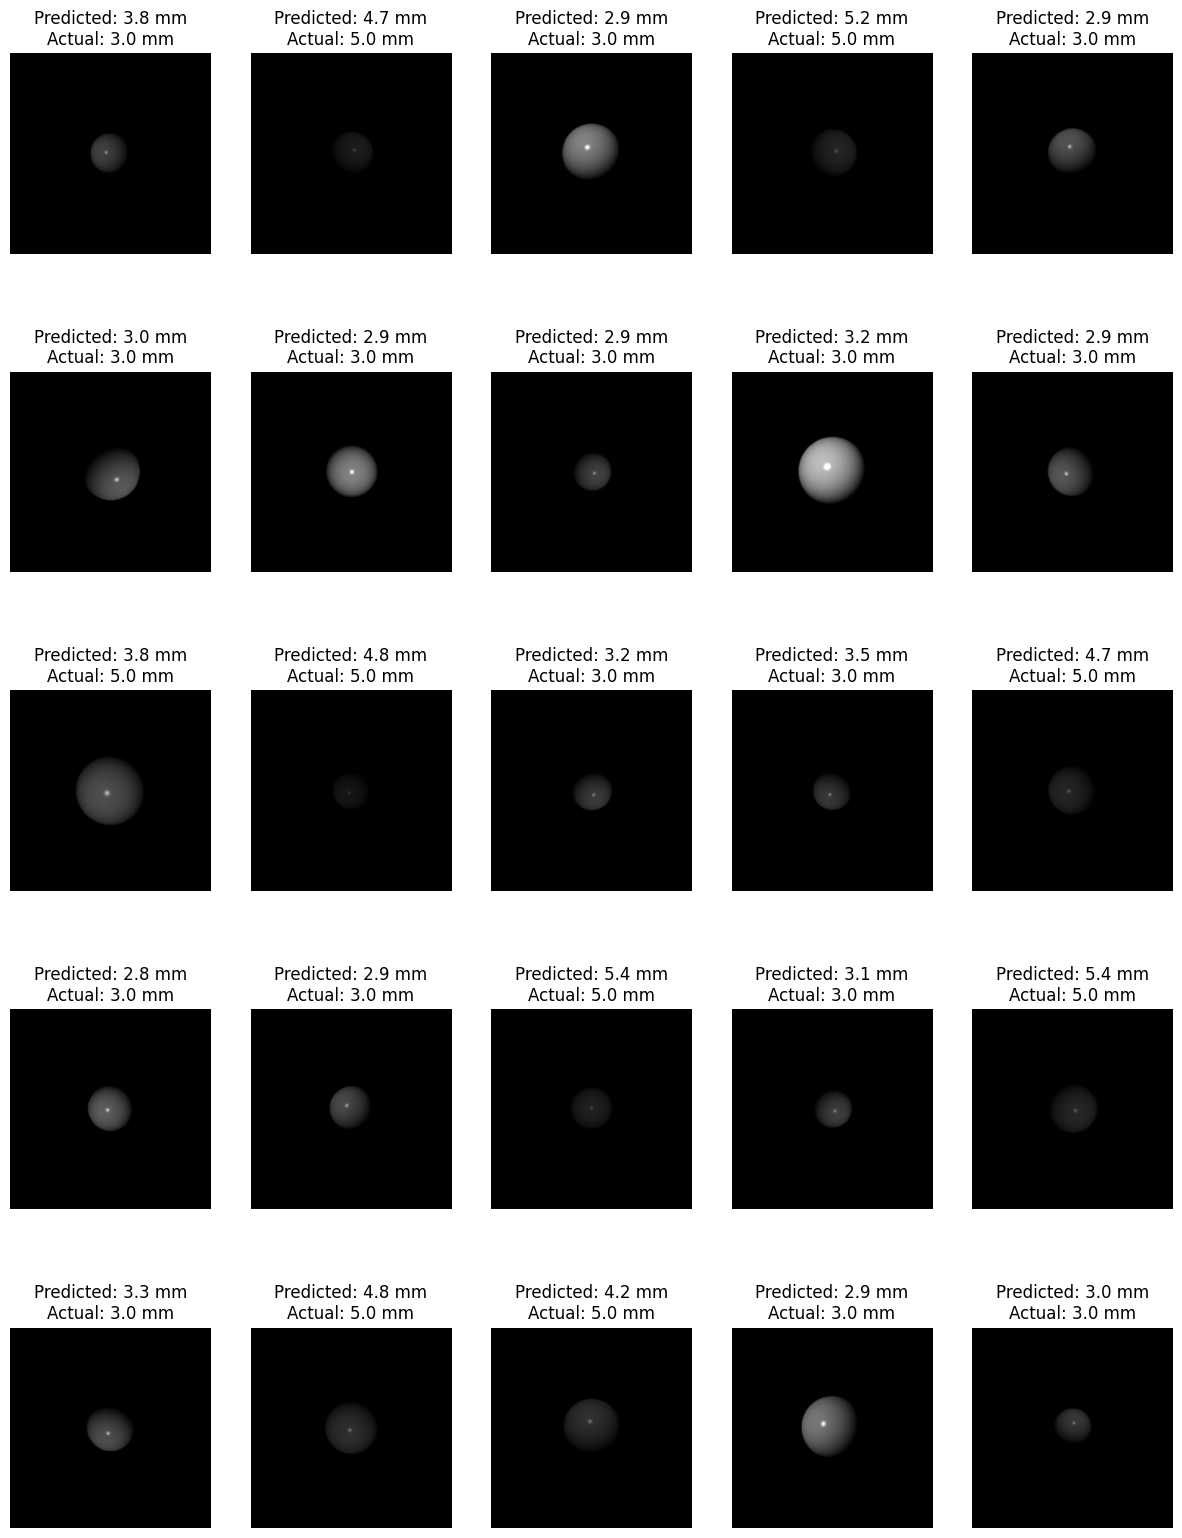

In [7]:
# ランダムに5つの画像を選択して表示
n_images =25
plt.figure(figsize=(15, 20))
indices = random.sample(range(len(all_images)), n_images)

for i, idx in enumerate(indices):
    image = all_images[idx].transpose((1, 2, 0))  # チャンネル順序を (H, W, C) に変更

    # 正規化を元に戻す
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # 正規化を元に戻す
    image = np.clip(image, 0, 1)  # 値を[0,1]範囲にクリップ

    # 推定結果と実際の値
    pred_size = all_preds[idx]
    actual_size = all_labels[idx]

    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {pred_size:.1f} mm\nActual: {actual_size:.1f} mm')
    plt.axis('off')

plt.show()